# Final Project
The goal of the project is to explore a number of datasets that may be associated with political instability in the U.S. The data was taken from the Seshat Databank under Creative Commons Attribution Non-Commercial (CC By-NC SA) licensing. You are asked to follow the steps and/or answer the questions below. It is permitted to work on the project in pairs or individually (1-2 students per project). If working in a group, please ensure that you include the names of both team members in your submission and on the document itself!

### Group Members
- Yordi Hernandez
- Dariel Cruz Rodriguez

***

In [ ]:
# Put any modules we need to import here so it all loads at the start of the code.

import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import seaborn as sns
plt.style.use('ggplot')

## Data Wrangling

* [X] Read the (short) code book.
* [X] Numerical data need to be uploaded, interpolated, and properly saved. For the purpose
of this project, interpolate each variable such that you obtain one point per year (within
the range of available data).
* [X] Calculate (and then interpolate) the political instability index.
* [x] Display the DataFrame with all of the columns and the interpolated data for the years
1901-1910.

In [38]:
# Yordi
# - PltEVI.csv
# - PltHeight.csv
# - PltHSUS.csv

In [39]:
dataframes = {
    "pltevi" : pd.read_csv("files/PltEVI.csv", header=None),
    "pltheight" : pd.read_csv("files/PltHeight.csv", header=None),
    "plthsus" : pd.read_csv("files/PltHSUS.csv", header=None),
}

column_mappings = {
    "pltevi": ["time", "EVI"],
    "pltheight": ["time", "Height(cm)"],
    "plthsus": ["time", "HSUS"],
}

for name, df in dataframes.items():
    df.columns = column_mappings[name] 
    df = df.iloc[1:].reset_index(drop=True) 
    df["time"] = df["time"].astype(float).round().astype(int) 
    df[df.columns[1]] = df[df.columns[1]].astype(float) 
    df = df.drop_duplicates(subset=["time"])  
    df = df.set_index("time").reindex(range(df["time"].min(), df["time"].max() + 1)).interpolate()
    df.reset_index(inplace=True)
    dataframes[name] = df

filtered_data = {name: df[(df["time"] >= 1901) & (df["time"] <= 1910)] for name, df in dataframes.items()}

yordi_joined = filtered_data["pltheight"].merge(filtered_data["pltevi"], on="time").merge(filtered_data["plthsus"], on="time")


In [40]:
yordi_joined.head(1)


,time,Height(cm),EVI,HSUS
0,1901,170.147403,1414.86613,30.66326


In [41]:
# Dariel
# - PltPolarizaiton.csv
# - PltWageGDPRatio.csv
# - USPVdatabase.xlsx

pltpolar = pd.read_csv("files/PltPolarization.csv", header=None, names=["year", "polarization"])
pltwage = pd.read_csv("files/PltWageGDPRatio.csv", header=None, names=["year", "ratio"])
uspv = pd.read_csv("files/USPVdatabase.csv")


In [42]:
# Dariel

#####################################
# Political Polarizaiton (pltpolar) #
#####################################

# Interpolating pltpolar by taking the mean so we have exactly one data point per year
# Structure: year, distance between the average scores of the Democrats/Republicans for each Congress
pltpolar["time"] = np.floor(pltpolar["year"])
pltpolar = pltpolar.groupby("time")["polarization"].mean().reset_index()
pltpolar["time"] = pltpolar["time"].apply(lambda x : int(x))

######################################
# Political Wage/GDP Ratio (pltwage) #
######################################

# Interpolating pltwage by taking the mean so we have exactly one data point per year
# Structure: year, ratio of blue collar wages/gdp per year
pltwage["time"] = np.floor(pltwage["year"])
pltwage = pltwage.groupby("time")["ratio"].mean().reset_index()
pltwage["time"] = pltwage["time"].apply(lambda x : int(x))

######################################
# Political Violence Database (uspv) #
######################################
uspv = uspv.drop(columns=["code","source","description", "location"])
uspv["time"] = np.floor(uspv["year"])
uspv = uspv.dropna()
uspv["time"] = uspv["time"].apply(lambda x : int(x))

pivot_type = pd.crosstab(uspv['time'], uspv['type'])
uspv = pivot_type

######################################
# JOINING DARIEL'S DATASETS TOGETHER #
######################################

# We can merge with Yordi's datasets later on the time column
dariel_joined = pd.merge(pltpolar, pltwage, on="time", how="outer")
dariel_joined = pd.merge(dariel_joined, uspv, on="time", how="outer")
dariel_joined[["assassination", "executions", "insurrection", "lynching",
               "mass suicide", "rampage", "riot", "terrorism", "war"]] = \
dariel_joined[["assassination", "executions", "insurrection", "lynching",
               "mass suicide", "rampage", "riot", "terrorism", "war"]].fillna(0)

years_wanted = [1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910]
dariel_joined = dariel_joined[dariel_joined["time"].isin(years_wanted)]
dariel_joined["time"] = dariel_joined["time"].apply(lambda x : str(x))
dariel_joined["ratio"] = dariel_joined["ratio"].interpolate(method='linear')
dariel_joined["total_deaths"] = dariel_joined[["assassination", "executions", "insurrection", "lynching",
                                               "mass suicide", "rampage", "riot", "terrorism", "war"]].sum(axis=1)
dariel_joined = dariel_joined.reset_index().drop(columns="index")

In [43]:
# Once both of us have wrangled our data, uncomment this and boom we have our data

yordi_joined["time"] = yordi_joined["time"].astype(int)
dariel_joined["time"] = dariel_joined["time"].astype(int)


df = pd.merge(dariel_joined, yordi_joined, left_on="time", right_on="time", how="outer")

In [44]:
df

,time,polarization,ratio,assassination,executions,insurrection,lynching,mass suicide,rampage,riot,terrorism,war,total_deaths,Height(cm),EVI,HSUS
0,1901,0.845472,0.651275,1.0,0.0,0.0,3.0,0.0,0.0,5.0,0.0,0.0,9.0,170.147403,1414.866130,30.663260
1,1902,0.860217,0.645180,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,5.0,170.381602,1474.485794,31.272835
2,1903,0.868912,0.639086,0.0,0.0,0.0,5.0,0.0,0.0,9.0,0.0,0.0,14.0,170.618785,1601.367749,31.312078
3,1904,0.877794,0.627711,0.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,9.0,170.726188,1667.193907,31.879503
4,1905,0.890111,0.606085,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,3.0,170.940995,1811.854852,32.514036
5,1906,0.898414,0.596688,0.0,0.0,0.0,3.0,0.0,0.0,10.0,0.0,0.0,13.0,171.161172,1888.826416,33.091095
6,1907,0.891646,0.607063,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,6.0,171.384034,1965.170701,33.132955
7,1908,0.882256,0.610940,0.0,0.0,0.0,9.0,0.0,0.0,5.0,0.0,0.0,14.0,171.621216,2137.097683,33.724216
8,1909,0.873668,0.608747,0.0,0.0,0.0,7.0,0.0,0.0,1.0,0.0,0.0,8.0,171.836023,2227.886274,34.314315
9,1910,0.860964,0.602996,0.0,0.0,0.0,5.0,0.0,0.0,19.0,1.0,0.0,25.0,172.080664,2325.601346,34.346872


## Exploratory Data Analysis
* [ ] Conduct an exploratory data analysis
* [ ] Summarize your main findings (most interesting/insightful conclusions) in a short paragraph and include appropriate visualizations.

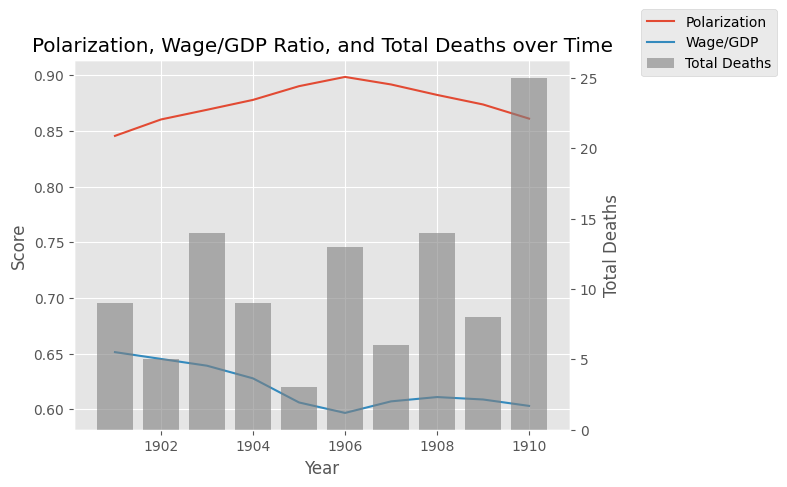

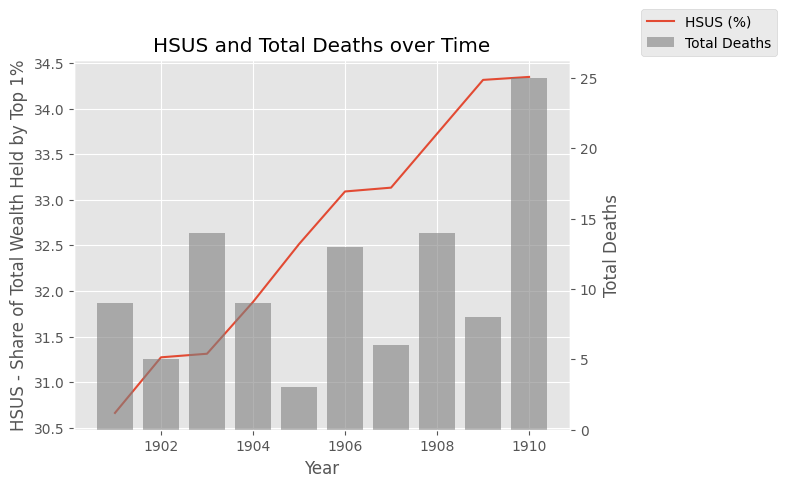

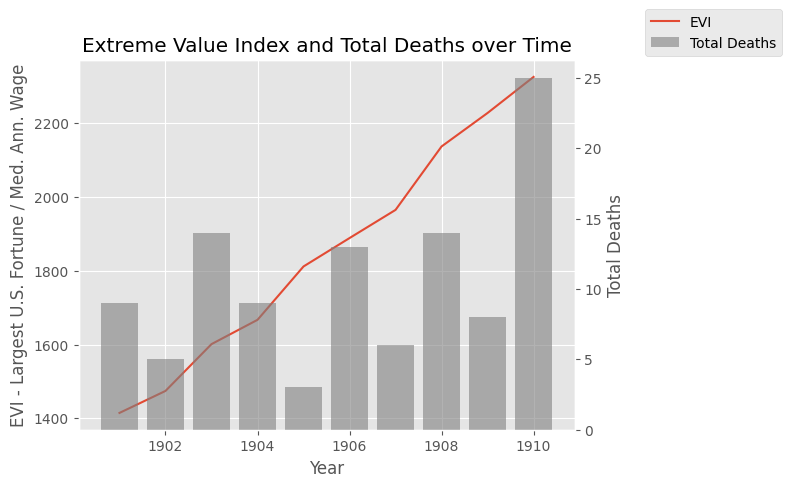

In [ ]:
# Dariel

fig, ax1 = plt.subplots()

ax1.set_xlabel("Year")
ax1.set_ylabel("Score")
ax1.plot("time", "polarization", data=df, label="Polarization")
ax1.plot("time", "ratio", data=df, label="Wage/GDP")

ax2 = ax1.twinx()
ax2.set_ylabel("Total Deaths")
ax2.bar("time", "total_deaths", data=df, alpha=0.6, color='gray', label="Total Deaths")

plt.title("Polarization, Wage/GDP Ratio, and Total Deaths over Time")
plt.grid()
fig.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

##############

fig, ax1 = plt.subplots()

ax1.set_xlabel("Year")
ax1.set_ylabel("HSUS - Share of Total Wealth Held by Top 1%")
ax1.plot("time", "HSUS", data=df, label="HSUS (%)")

ax2 = ax1.twinx()
ax2.set_ylabel("Total Deaths")
ax2.bar("time", "total_deaths", data=df, alpha=0.6, color='gray', label="Total Deaths")

plt.title("HSUS and Total Deaths over Time")
plt.grid()
fig.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

##############

fig, ax1 = plt.subplots()

ax1.set_xlabel("Year")
ax1.set_ylabel("EVI - Largest U.S. Fortune / Med. Ann. Wage")
ax1.plot("time", "EVI", data=df, label="EVI")

ax2 = ax1.twinx()
ax2.set_ylabel("Total Deaths")
ax2.bar("time", "total_deaths", data=df, alpha=0.6, color='gray', label="Total Deaths")

plt.title("Extreme Value Index and Total Deaths over Time")
plt.grid()
fig.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.show()

In [52]:
df.describe()

,time,polarization,ratio,assassination,executions,insurrection,lynching,mass suicide,rampage,riot,terrorism,war,total_deaths,Height(cm),EVI,HSUS
count,10.00000,10.000000,10.000000,10.000000,10.0,10.0,10.000000,10.0,10.0,10.000000,10.000000,10.0,10.000000,10.000000,10.000000,10.000000
mean,1905.50000,0.874945,0.619577,0.200000,0.0,0.0,3.900000,0.0,0.0,6.400000,0.100000,0.0,10.600000,171.089808,1851.435085,32.625117
std,3.02765,0.016467,0.019540,0.421637,0.0,0.0,2.806738,0.0,0.0,5.295701,0.316228,0.0,6.310485,0.639322,315.033413,1.311097
min,1901.00000,0.845472,0.596688,0.000000,0.0,0.0,0.000000,0.0,0.0,1.000000,0.000000,0.0,3.000000,170.147403,1414.866130,30.663260
25%,1903.25000,0.862951,0.606329,0.000000,0.0,0.0,3.000000,0.0,0.0,2.750000,0.000000,0.0,6.500000,170.645636,1617.824289,31.453934
50%,1905.50000,0.875731,0.609843,0.000000,0.0,0.0,3.500000,0.0,0.0,5.000000,0.000000,0.0,9.000000,171.051083,1850.340634,32.802566
75%,1907.75000,0.888147,0.636242,0.000000,0.0,0.0,5.000000,0.0,0.0,8.250000,0.000000,0.0,13.750000,171.561920,2094.115938,33.576401
max,1910.00000,0.898414,0.651275,1.000000,0.0,0.0,9.000000,0.0,0.0,19.000000,1.000000,0.0,25.000000,172.080664,2325.601346,34.346872


In [53]:
df.isnull().sum()

time             0
polarization     0
ratio            0
assassination    0
executions       0
insurrection     0
lynching         0
mass suicide     0
rampage          0
riot             0
terrorism        0
war              0
total_deaths     0
Height(cm)       0
EVI              0
HSUS             0
dtype: int64

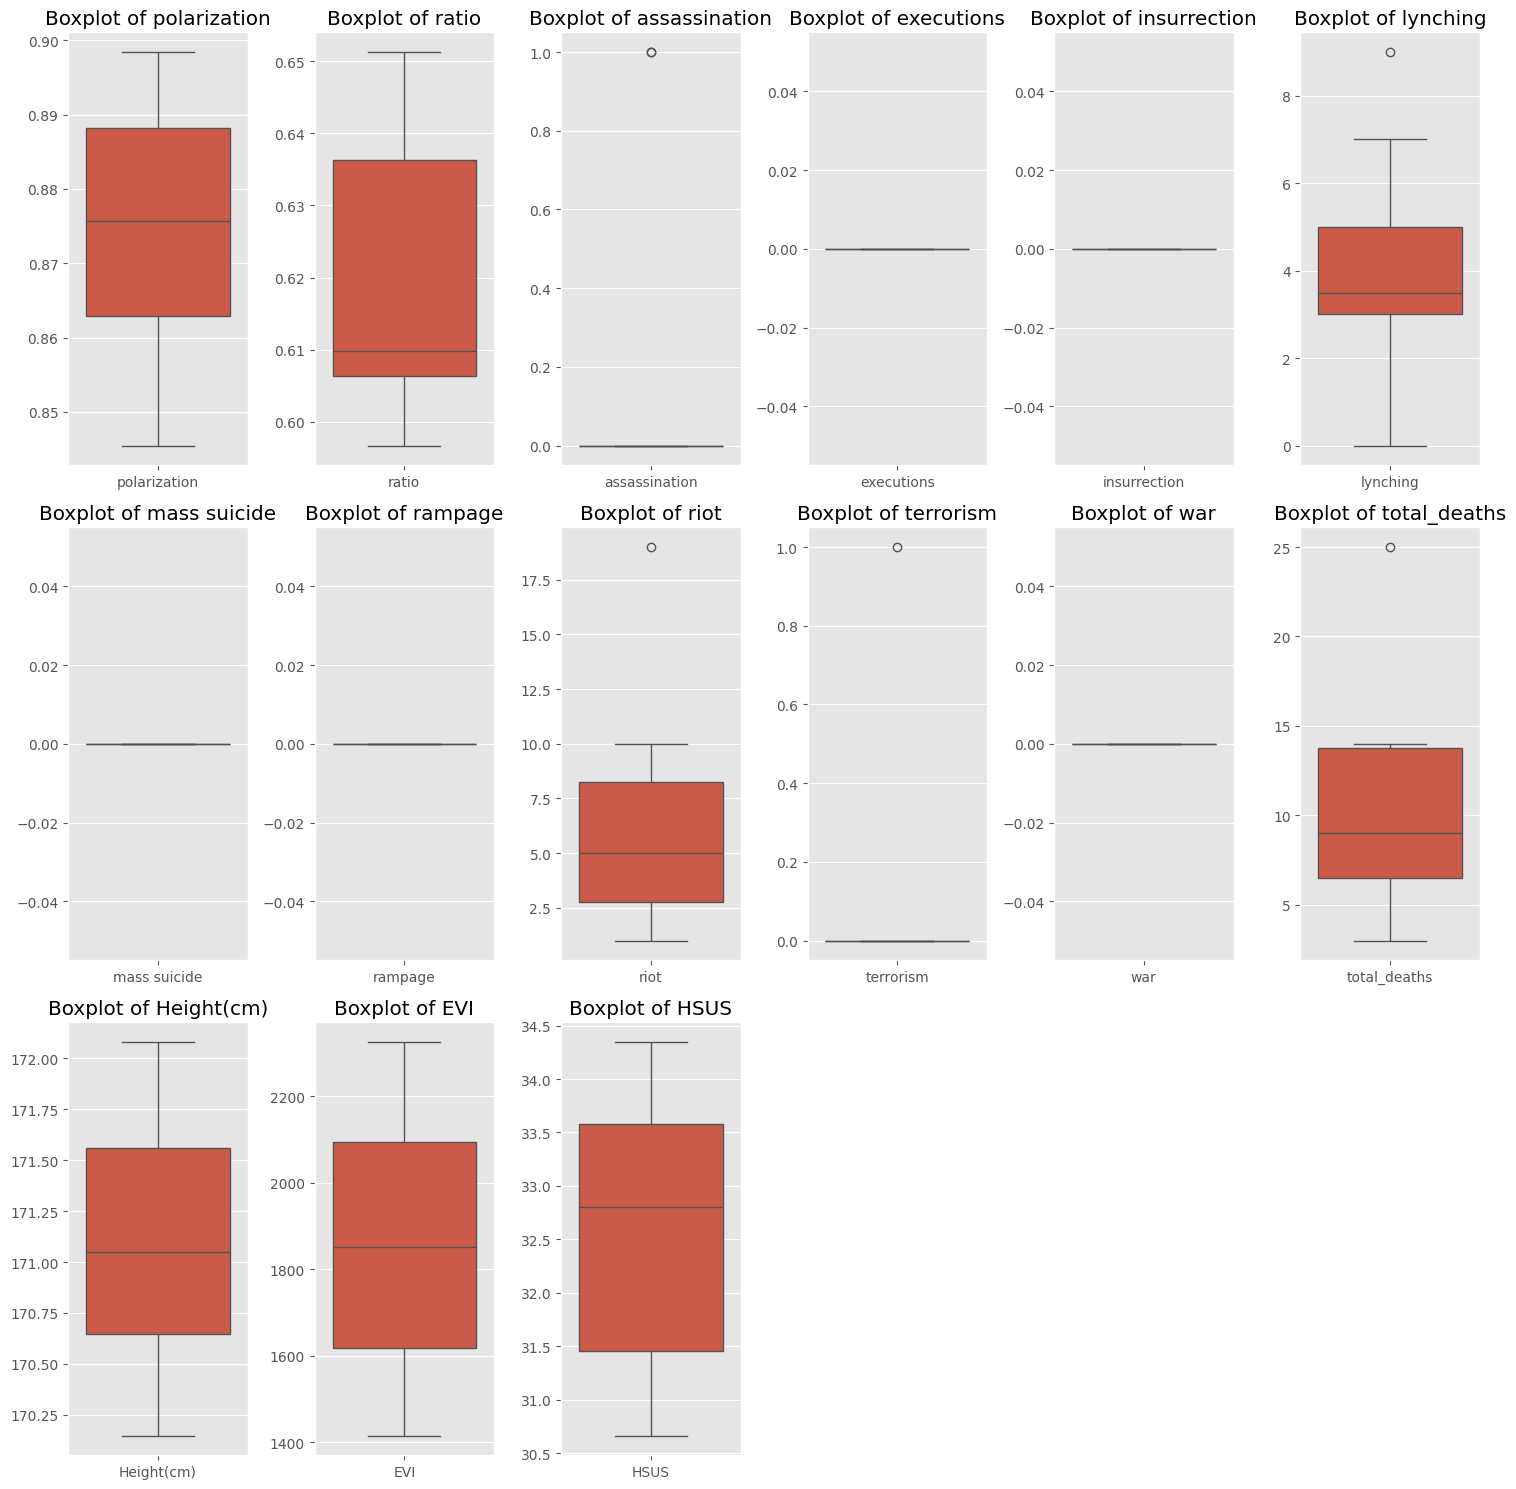

In [85]:
# List of columns to plot
columns_to_plot = df.columns.drop(['time'])

# Number of columns for subplots
n_cols = 6
n_rows = (len(columns_to_plot) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

for i, col in enumerate(columns_to_plot):
    row = i // n_cols
    col_idx = i % n_cols
    sns.boxplot(data=df[[col]], ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Boxplot of {col}')

# Remove empty subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()


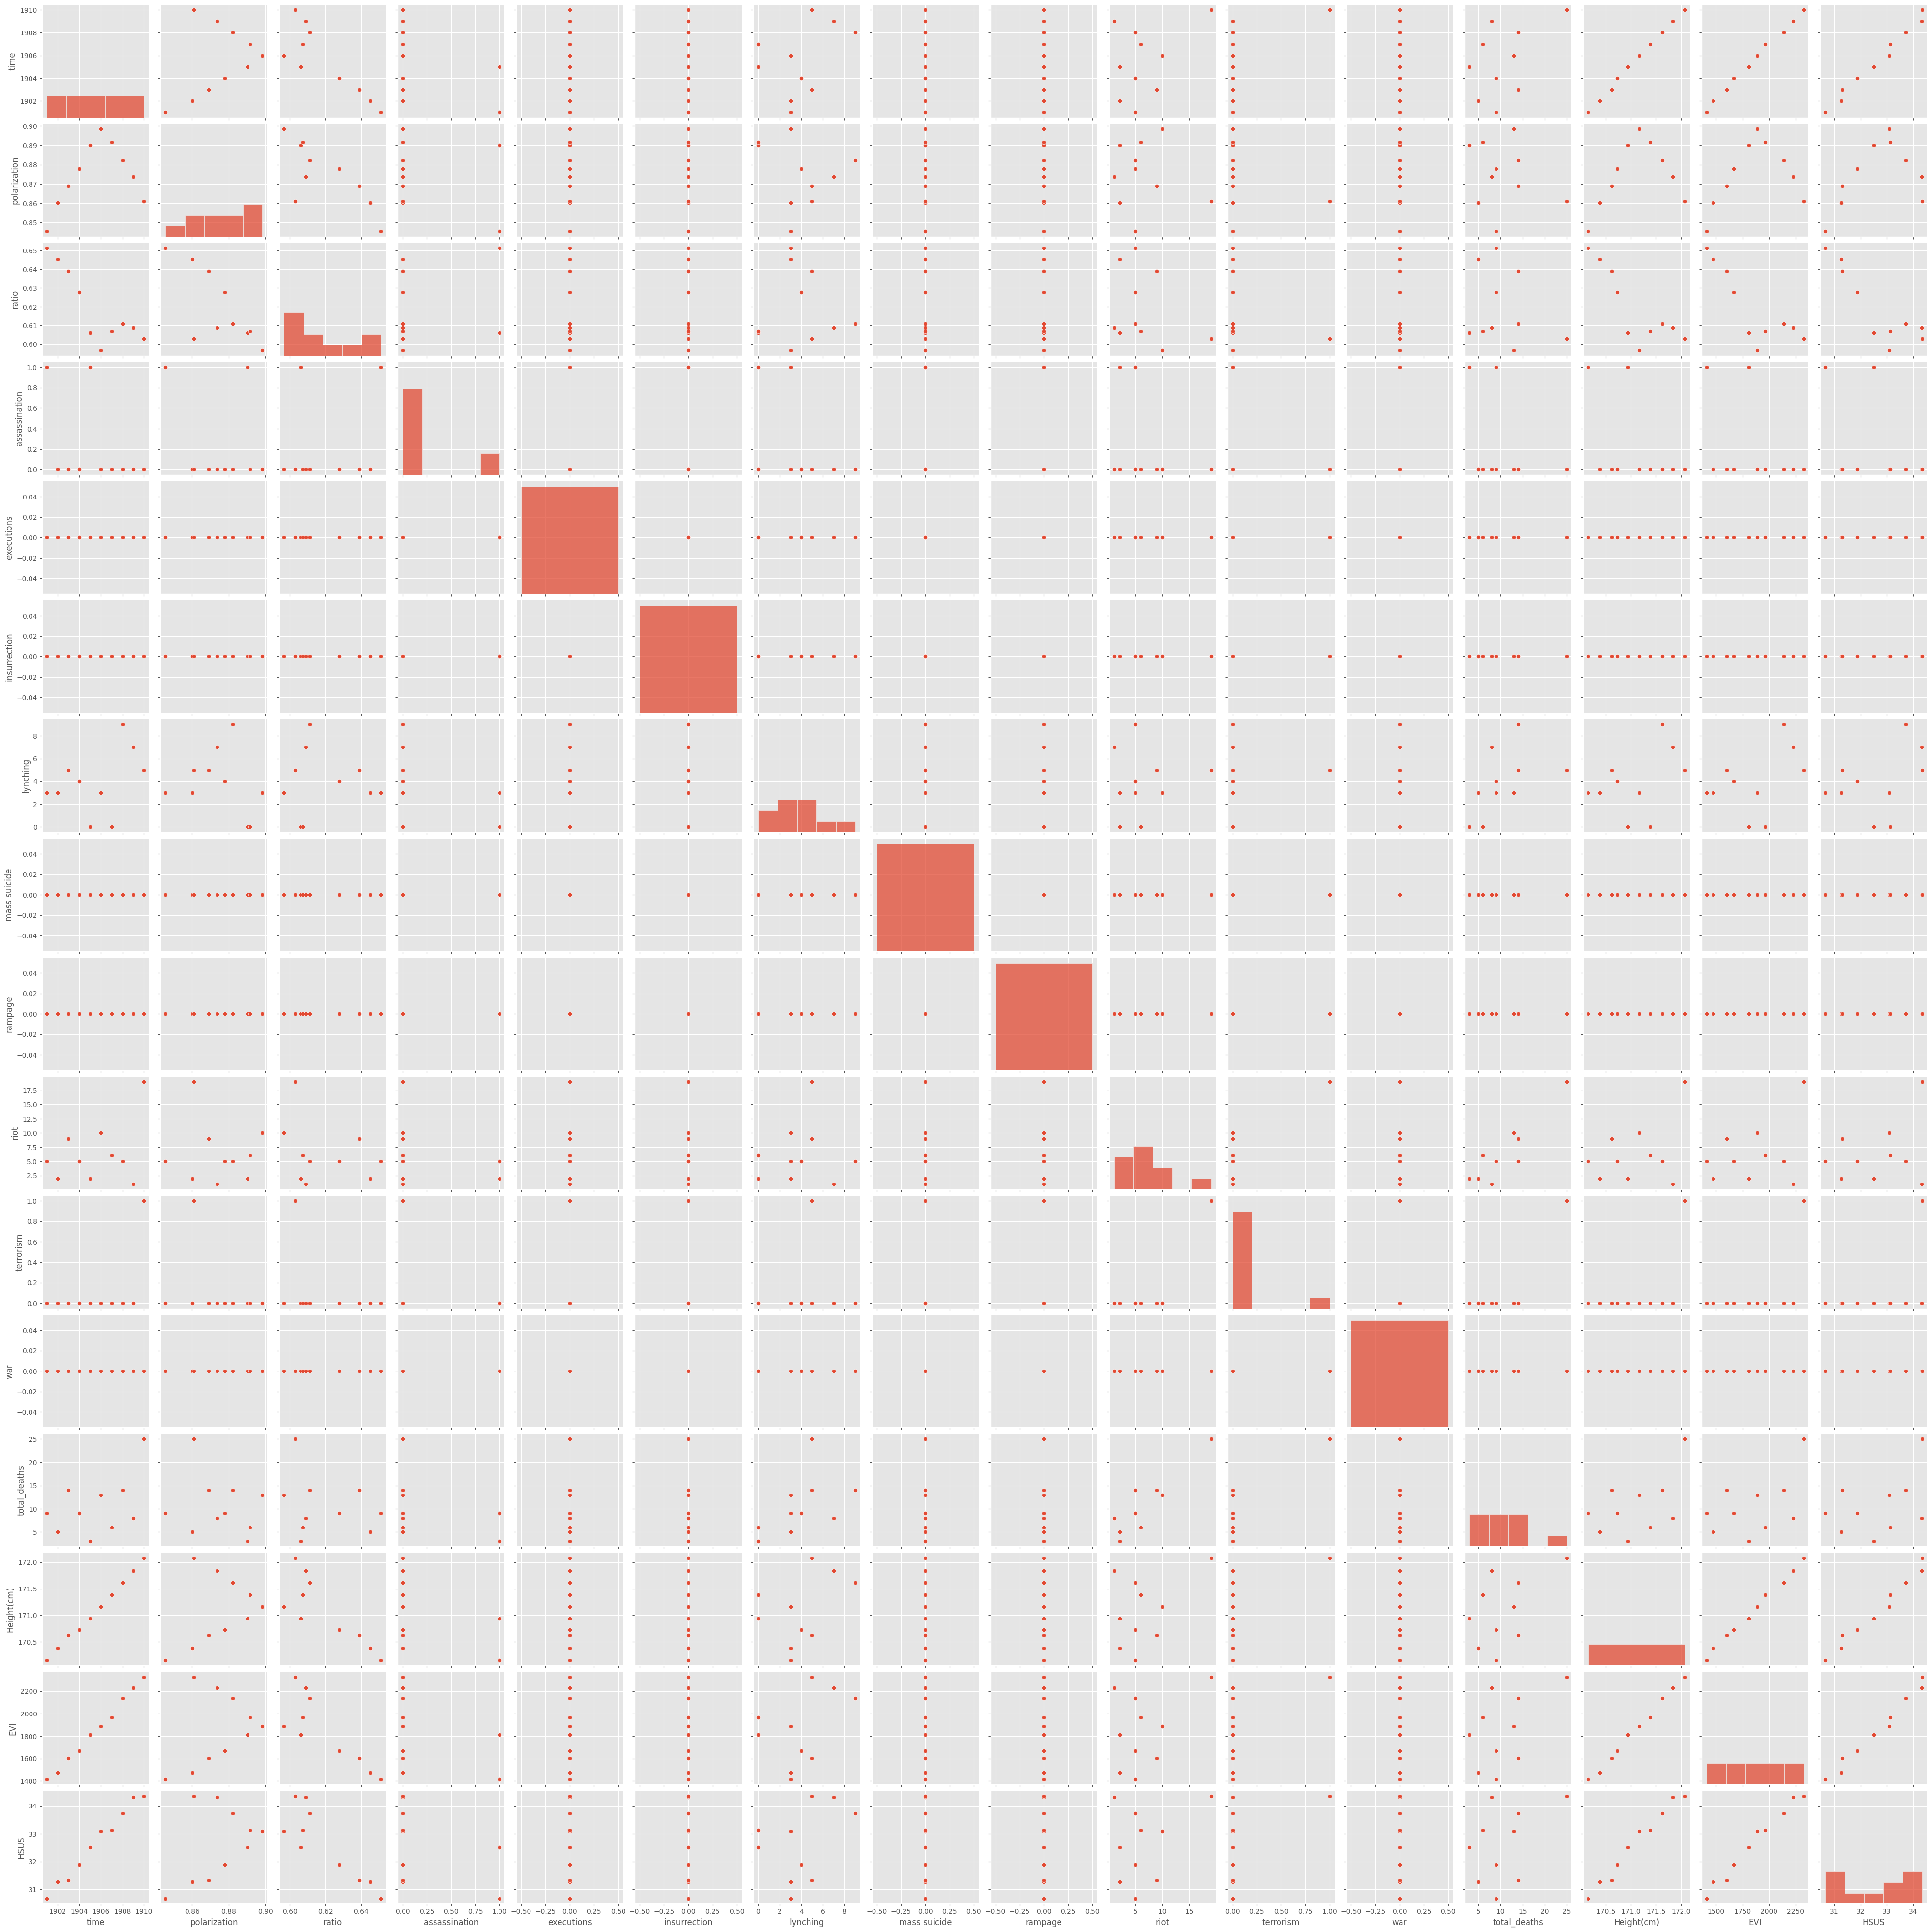

In [60]:
sns.pairplot(df)
plt.show()

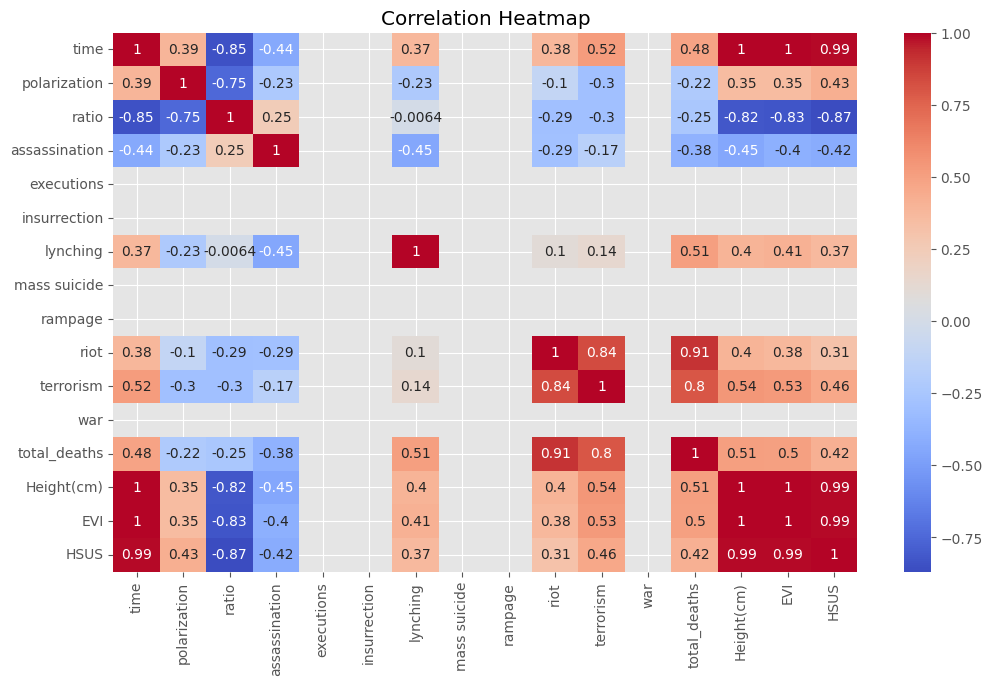

In [72]:
plt.figure(figsize=(12, 7))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Find the best regressor
Find the best regressor that would predict the instability index from the various predictors. To be clear, you are asked to compare a limited set of regressors of your choice – not to identify the theoretically optimal one.

* [ ] Explain your modeling choices.
* [ ] Interpret any evaluation metrics you use.
* [ ] Summarize your conclusions in a short paragraph, i.e., the most interesting conclusion(s), the model that produced it, and how the model was chosen. You may include a figure if you find it helpful.

## Find the best dimensionality reduction for regression
You can restrict this part to reducing the data to two dimensions, to three dimensions, or explore both options. You can test your variables using the best regressor found in the previous section or a small number of regressors (2-3 models at most).

* [ ] Explain modeling choices and evaluation metrics.
* [ ] Summarize your conclusions in a short paragraph, i.e., the most interesting conclusion(s), the model that produced it, and how the model was chosen. You may include a figure if you find it helpful

## Find the best dimensionality reduction for unsupervised classification

Use only the predictor columns and not the outcome (instability) for classification. You can restrict this part to reducing the data to two dimensions, to three dimensions, or explore both options.

* [ ] You can test your variables using k-means or a small number of classifiers (2-3 models at most).
* [ ] Explain modeling choices and evaluation metrics.
* [ ] Summarize your conclusions in a short paragraph, i.e., the most interesting conclusion(s), the model that produced it, and how the model was chosen. You may include a figure if you find it helpful.

## Briefly explore the clusters of instability scores

Consider the cluster labels from the best clustering scheme from previous section or from clustering using all/most of the original features. Apply it to the corresponding records of the outcome column (instability).

* [ ] Create a visualization of the results.
* [ ] Summarize your conclusions. To be clear, the summary can be very short, and may be that the clusters do not exhibit any discernable or interpretable pattern. You may include a figure if you find it helpful.

## Consider a real life modeling/prediction problem

* [ ] Try a large number (100? 1000?) different models
* [ ] Examine their performances
* [ ] Select the one that scores best on your performance metric of choice
* [ ] Briefly discuss the potential disadvantage (or potential danger) of such and approach and how you might go about mitigating it.